In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import h5py

from PIL import Image
import cv2

In [2]:
with h5py.File("../datasets/features2_tokyo.h5", "r") as f:
    features = f["features2_tokyo"][:]

In [3]:
# padding = 3
padding = 9

In [4]:
if padding is not None:
    with h5py.File(fr"../datasets/padding/labels_tokyo_padding{padding}.h5", "r") as f:
        labels = f["labels"][:]

else:
    with h5py.File(fr"../datasets/labels_tokyo.h5", "r") as f:
        labels = f["labels"][:]

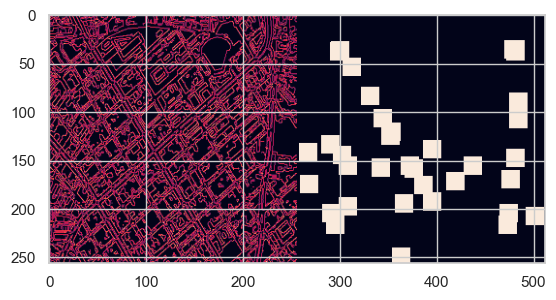

10552.0
16.10107421875


In [14]:
import random

# rand_idx = random.randint(0, features.shape[0])
rand_idx = 17
display_img = np.hstack((features[rand_idx], labels[rand_idx] * 256))

# display_img_3d = np.concatenate([
#     np.expand_dims(display_img, 0),
#     np.zeros((2, features.shape[1], 2 * features.shape[1]))
# ], axis=0)

plt.imshow(display_img)
plt.show()

print(labels[rand_idx].sum())
print((labels[rand_idx].sum() / (256 * 256)) * 100)

Using `rand_idx = 17` gives a good idea. Imbalance is 8.01%.

In [6]:
# How many of the meshes are empty (have no accidents recorded)?
nonempty_indexes = np.array([i for i in range(labels.shape[0]) if labels[i].sum() > 0.5])
len(nonempty_indexes)

256

249 is barely anything! Only 18% of labels aren't empty. That's the imbalance, not the pixels *within* each of the images.

In [7]:
nonempty_features = features[nonempty_indexes]
nonempty_labels = labels[nonempty_indexes]

def generate_quadrants(images):
    height, width = images.shape[1], images.shape[2]
    half_height, half_width = height // 2, width // 2

    top_left = images[:, :half_height, :half_width]
    top_right = images[:, :half_height, half_width:]
    bottom_left = images[:, half_height:, :half_width]
    bottom_right = images[:, half_height:, half_width:]

    quadrants = np.stack([top_left, top_right, bottom_left, bottom_right], axis=1)
    return quadrants

nonempty_feature_quadrants = generate_quadrants(nonempty_features)
nonempty_label_quadrants = generate_quadrants(nonempty_labels)

nonempty_feature_quadrants = nonempty_feature_quadrants.reshape(-1, 128, 128)
nonempty_label_quadrants = nonempty_label_quadrants.reshape(-1, 128, 128)

nonempty_feature_quadrants.shape, nonempty_label_quadrants.shape

((1024, 128, 128), (1024, 128, 128))

In [8]:
# Apply removing empty features again
# removes quadrants that are empty (but the original mesh isn't necessarily empty)

nonempty_indexes2 = np.array([
    i for i in range(nonempty_label_quadrants.shape[0]) if nonempty_label_quadrants[i].sum() > 0.5])
print(len(nonempty_indexes2))

nonempty_feature_quadrants = nonempty_feature_quadrants[nonempty_indexes2]
nonempty_label_quadrants = nonempty_label_quadrants[nonempty_indexes2]

876


In [9]:
hdf5_filename = fr'../datasets/balanced/features_tokyo_padding9.h5'
with h5py.File(hdf5_filename, 'w') as hdf5_file:
    hdf5_file.create_dataset('features', data=nonempty_feature_quadrants, compression='gzip', compression_opts=9)

In [10]:
if padding is not None:
    hdf5_filename = fr'../datasets/balanced/labels_tokyo_padding{padding}.h5'
    with h5py.File(hdf5_filename, 'w') as hdf5_file:
        hdf5_file.create_dataset('labels', data=nonempty_label_quadrants, compression='gzip', compression_opts=9)

else:
    hdf5_filename = fr'../datasets/balanced/labels_tokyo.h5'
    with h5py.File(hdf5_filename, 'w') as hdf5_file:
        hdf5_file.create_dataset('labels', data=nonempty_label_quadrants, compression='gzip', compression_opts=9)

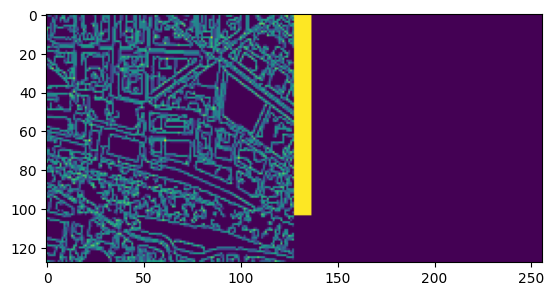

936.0
5.71% of data is covered


In [11]:
import random

# rand_idx = 304
rand_idx = random.randint(0, nonempty_feature_quadrants.shape[0])
display_img = np.hstack((nonempty_feature_quadrants[rand_idx], nonempty_label_quadrants[rand_idx] * 256))

plt.imshow(display_img)
plt.show()

print(nonempty_label_quadrants[rand_idx].sum())
print(round((nonempty_label_quadrants[rand_idx].sum() / (128 * 128)) * 100, 2), '% of data is covered', sep='')

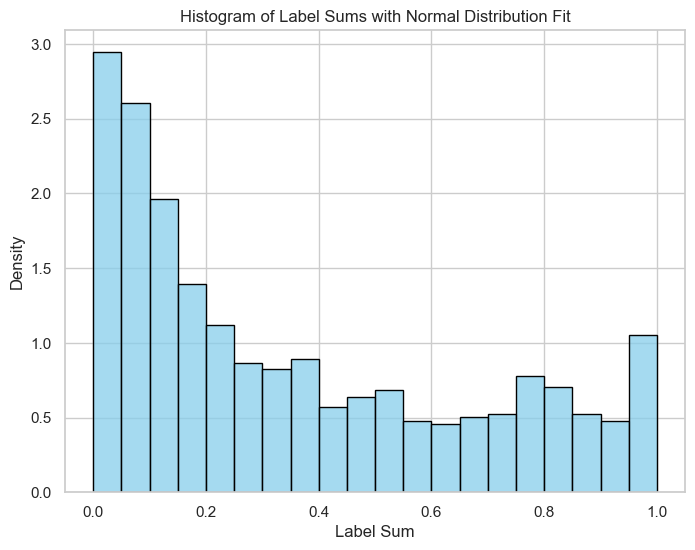

In [12]:
import seaborn as sns

label_sums = nonempty_label_quadrants.sum(axis=(1, 2))
label_sums /= (128 * 128)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.histplot(label_sums, kde=False, stat='density', bins=20, color='skyblue', edgecolor='black')

plt.title("Histogram of Label Sums with Normal Distribution Fit")
plt.xlabel("Label Sum")
plt.ylabel("Density")

plt.show()

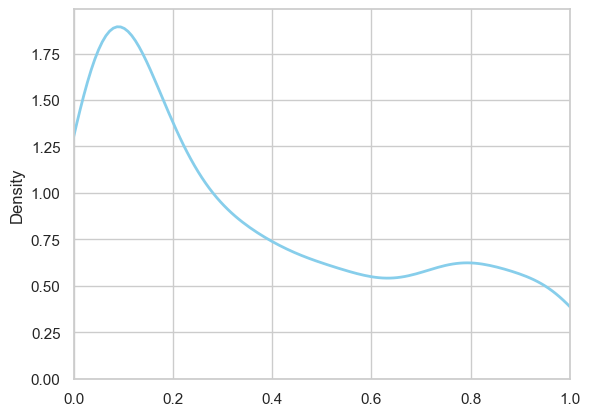

In [13]:
sns.kdeplot(label_sums, fill=False, color='skyblue', linestyle='-', linewidth=2)
plt.xlim(0, 1.0)
plt.show()